# Adaptive QPE

**Download this notebook - {nb-download}`adaptive-qpe.ipynb`**

Implementation of the adaptive random walk phase estimation algorithm from
https://arxiv.org/abs/2208.04526.

The example Hamiltonian and numbers are taken from https://arxiv.org/abs/2206.12950.

In [1]:
import math
from guppylang import guppy
from guppylang.std.angles import angle
from guppylang.std.builtins import comptime, result
from guppylang.std.quantum import discard, measure, qubit, h, rz, x, crz

In [2]:
@guppy
def oracle(ctrl: qubit, q: qubit, t: float) -> None:
    """Applies a controlled e^-iπHt/2 gate for the example Hamiltonian H = 0.5 * Z."""
    crz(ctrl, q, angle(0.5 * t))


@guppy
def eigenstate() -> qubit:
    """Prepares eigenstate of the example Hamiltonian H = 0.5 * Z."""
    q = qubit()
    x(q)
    return q

In [3]:
sqrt_e = math.sqrt(math.e)
sqrt_e_div = math.sqrt((math.e - 1) / math.e)


@guppy
def main() -> None:
    # Pick initial estimate of phase mean and stdv
    # and prepare eigenstate
    mu, sigma = comptime(sqrt_e_div), 1 / comptime(sqrt_e)
    tgt = eigenstate()
    for _ in range(24):
        t = 1 / sigma

        aux = qubit()
        h(aux)
        rz(aux, angle((sigma - mu) * t))
        oracle(aux, tgt, t)
        h(aux)

        if measure(aux):
            mu += sigma / comptime(sqrt_e)
        else:
            mu -= sigma / comptime(sqrt_e)
        sigma *= comptime(sqrt_e_div)

    discard(tgt)
    result("eigenvalue", 2 * mu)

In [4]:
from guppylang.emulator import EmulatorOpts
# single shot statevector emulator
opts = EmulatorOpts.statevector().with_random_seed(2)

main.run_emulator(n_qubits=2, options=opts)

EmulatorResult(results=[QsysShot(entries=[('eigenvalue', 2.3679925580437398)])])

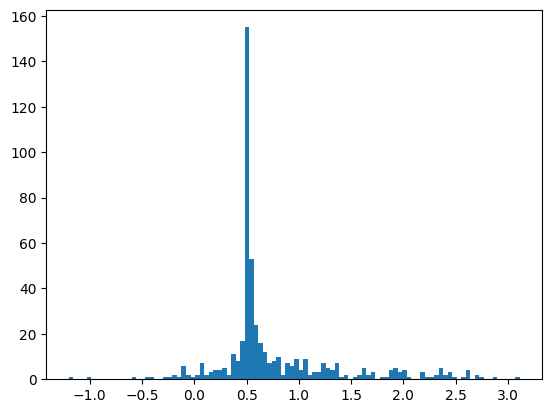

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# run more shots
shots = main.run_emulator(n_qubits=2, options=opts.with_n_shots(500))
fig, ax = plt.subplots(1, 1)
ax.hist([shot.as_dict()["eigenvalue"] for shot in shots.results], bins=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.show()